In [17]:
from dataset import TranSiGenDataset
from model import TranSiGen
from utils import *
import pickle
import warnings
import torch
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Carregamento dos dados

Os dados são carregados a partir de um arquivo `.h5`:

In [20]:
data_path = '../data/LINCS2020/data_example/processed_data_id.h5'

In [21]:
data = load_from_HDF(data_path)

In [22]:
cell_count = len(set(data['cid']))
feat_type = 'KPGT'
batch_size = 64
learning_rate = 1e-3
beta = 0.1
dropout = 0.1
weight_decay = 1e-5
n_folds = 5
random_seed = 364039
split_type = 'smiles_split'
features_dim = 2304
features_embed_dim = [400]
n_latent = 100
# init_mode = 'pretrain_shRNA'
init_mode = 'random'
n_epochs = 300
molecule_path = '../data/LINCS2020/idx2smi.pickle'

In [23]:
local_out = '../results/trained_models_{}_cell_{}/{}/feature_{}_init_{}/'.format(cell_count, split_type, random_seed, feat_type, init_mode)

In [24]:
with open(molecule_path, 'rb') as f:
    idx2smi = pickle.load(f)

## Divisão de treino e teste

In [25]:
pair, pairv, pairt = split_data(data, n_folds=n_folds, split_type=split_type, rnds=random_seed)

In [26]:
train = TranSiGenDataset(
    LINCS_index=pair['LINCS_index'],
    mol_feature_type=feat_type,
    mol_id=pair['canonical_smiles'],
    cid=pair['cid']
)

valid = TranSiGenDataset(
    LINCS_index=pairv['LINCS_index'],
    mol_feature_type=feat_type,
    mol_id=pairv['canonical_smiles'],
    cid=pairv['cid']
)

test = TranSiGenDataset(
    LINCS_index=pairt['LINCS_index'],
    mol_feature_type=feat_type,
    mol_id=pairt['canonical_smiles'],
    cid=pairt['cid']
)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4, worker_init_fn=seed_worker)
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4, worker_init_fn=seed_worker)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4, worker_init_fn=seed_worker)

## Criação do Modelo

In [27]:
model = TranSiGen(
    n_genes=978,
    n_latent=n_latent,
    n_en_hidden=[1200],
    n_de_hidden=[800],
    features_dim=features_dim,
    features_embed_dim=features_embed_dim,
    init_w=True,
    beta=beta,
    device=dev,
    dropout=dropout,
    path_model=local_out,
    random_seed=random_seed
)

In [28]:
_ = model.to(dev)

## Treinamento/Carregamento do Modelo

In [29]:
epoch_hist, best_epoch = model.train_model(
    train_loader=train_loader,
    test_loader=valid_loader,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    save_model=False
)

[Epoch 0] | loss: nan, mse_x1_rec: 9318890.585, mse_x2_rec: 8670694.972, mse_pert: nan, kld_x1: 4735555.108, kld_x2: 4342135.277, kld_pert: inf| valid_loss: nan, valid_mse_x1_rec: 8587624.889, valid_mse_x2_rec: 5622257.778, valid_mse_pert: nan, valid_kld_x1: 4556903.111, valid_kld_x2: 4978706.667, valid_kld_pert: inf|
[Epoch 1] | loss: nan, mse_x1_rec: 52761561.477, mse_x2_rec: 3337790.031, mse_pert: nan, kld_x1: 17241765.300, kld_x2: 802343.590, kld_pert: inf| valid_loss: nan, valid_mse_x1_rec: 89357966.222, valid_mse_x2_rec: 4927481.778, valid_mse_pert: nan, valid_kld_x1: 20299991.111, valid_kld_x2: 1406433.333, valid_kld_pert: inf|
[Epoch 2] | loss: nan, mse_x1_rec: 1089899976.862, mse_x2_rec: 8905099.292, mse_pert: nan, kld_x1: 69633987.938, kld_x2: 1182406.058, kld_pert: inf| valid_loss: nan, valid_mse_x1_rec: 527045859.556, valid_mse_x2_rec: 7424124.444, valid_mse_pert: nan, valid_kld_x1: 71853112.889, valid_kld_x2: 1405019.556, valid_kld_pert: inf|
[Epoch 3] | loss: nan, mse_x1_

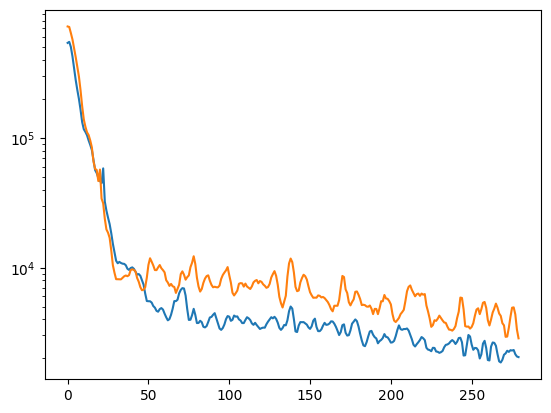

In [30]:
plt.plot(epoch_hist['train_loss'][20:])
plt.plot(epoch_hist['valid_loss'][20:])
plt.yscale('log')

## Avaliação do Modelo no Conjunto Teste

In [31]:
_, _, test_metrics_dict_ls = model.test_model(loader=test_loader, metrics_func=['pearson', 'rmse', 'precision100'])

for name, rec_dict_value in zip(['test'], [test_metrics_dict_ls]):
    df_rec = pd.DataFrame.from_dict(rec_dict_value)
    smi_ls = []
    for smi_id in df_rec['cp_id']:
        smi_ls.append(idx2smi[smi_id])
    df_rec['canonical_smiles'] = smi_ls

In [32]:
df_rec

,x1_rec_pearson,x1_rec_rmse,x1_rec_neg_precision100,x1_rec_pos_precision100,x2_rec_pearson,x2_rec_rmse,x2_rec_neg_precision100,x2_rec_pos_precision100,x2_pred_pearson,x2_pred_rmse,...,DEG_rec_neg_precision100,DEG_rec_pos_precision100,DEG_pred_pearson,DEG_pred_rmse,DEG_pred_neg_precision100,DEG_pred_pos_precision100,cp_id,cid,sig,canonical_smiles
0,0.971083,0.647711,0.83,0.85,0.944962,1.069313,0.78,0.79,0.937997,0.929980,...,0.23,0.23,0.246458,0.929980,0.19,0.20,9,PC3,PC3_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
1,0.951219,1.013272,0.84,0.76,0.943540,0.823634,0.77,0.77,0.926769,3.111538,...,0.29,0.25,0.226935,3.111538,0.18,0.17,9,HA1E,HA1E_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
2,0.977329,0.538664,0.87,0.87,0.963241,0.642304,0.81,0.79,0.951269,1.963853,...,0.29,0.27,0.258899,1.963853,0.13,0.19,13,HA1E,HA1E_13,Brc1ccc(NC(=O)N2NC(=O)[C@H]([C@@H]2c2ccccc2)c2...
3,0.952208,1.006990,0.84,0.76,0.941861,0.840590,0.73,0.80,0.919020,2.555735,...,0.21,0.24,0.212561,2.555735,0.10,0.21,6,HA1E,HA1E_6,Brc1c[nH]c2nc(SCc3ccccc3C#N)nc2c1
4,0.906241,1.244107,0.74,0.72,0.949572,0.890698,0.84,0.79,0.935782,2.250289,...,0.32,0.59,0.538510,2.250289,0.18,0.51,9,VCAP,VCAP_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
5,0.942161,0.979840,0.79,0.76,0.940658,0.838945,0.76,0.76,0.927624,2.123711,...,0.44,0.33,0.336642,2.123711,0.28,0.22,9,MCF7,MCF7_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
6,0.937152,1.535280,0.79,0.80,0.931947,1.234862,0.76,0.76,0.916632,2.139915,...,0.18,0.24,0.143778,2.139915,0.11,0.22,6,A549,A549_6,Brc1c[nH]c2nc(SCc3ccccc3C#N)nc2c1
7,0.968252,0.570882,0.83,0.82,0.948634,0.936033,0.82,0.79,0.938713,1.011783,...,0.29,0.38,0.510259,1.011783,0.18,0.35,13,ASC,ASC_13,Brc1ccc(NC(=O)N2NC(=O)[C@H]([C@@H]2c2ccccc2)c2...
8,0.919220,2.114700,0.68,0.76,0.895378,2.034641,0.68,0.73,0.867673,2.951653,...,0.20,0.23,0.214176,2.951653,0.13,0.19,9,A375,A375_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
9,0.857585,2.862830,0.63,0.59,0.849315,2.616305,0.60,0.66,0.847360,2.976398,...,0.15,0.21,0.180716,2.976398,0.12,0.20,6,HT29,HT29_6,Brc1c[nH]c2nc(SCc3ccccc3C#N)nc2c1
